#### Import required  libraries
* install the below packages if missing

```bash
    %pip install pandas numpy tensorflow scikit-learn plotly matplotlib
```

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

#### Data Preparation 

####  1.1 Set the stock symbol

In [7]:
stock='GOOG'

#####  1.2 Method to create data sets with lags

In [ ]:
def create_dataset(data, lag=1):
    """ method to create data sets with lags
    Args:
        data (_type_):  DataFrame
        lag (int, optional): Lag time. Defaults to 1.

    Returns:
        X,y,indices: Returns the X with lag from current time step  t to t-lag
    """
    X, y = [], []
    indices=[]
    for i in range(len(data) - lag):
        X.append(data[i:(i + lag), 0])
        indices.append(df_stock.index[i + lag])
        y.append(data[i + lag, 0])
    return np.array(X), np.array(y),indices

#### 1.3 Create Test ans train Data set
*  Get the weekly data 
*  We will use the Adjusted Close
*  Normalize with Min Max Scaler
*  Create Data Set with lag
*  Set the split 

In [10]:
df_stock = pd.read_csv(f'./data/{stock}_weekly_adjusted.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
ddf_stock=df_stock.sort_index(ascending=True,inplace=True) ## As the Data is in Descending order

ts = df_stock['Adjusted Close'].values

# Use the 'Adjusted Close' prices for analysis
ts = df_stock['Adjusted Close'].values

# Normalize the actual prices
scaler = MinMaxScaler()
ts = ts.reshape(-1, 1)  # Reshape for scaler
ts_scaled = scaler.fit_transform(ts)

# Set time step for LSTM
time_step = 10  # Number of previous days to use for predicting the next day
X, y,dates = create_dataset(ts_scaled, time_step)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### 1.4 Print the Shape of Test and Train Data

In [13]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(436, 10) (109, 10)
(436,) (109,)


### Base Line Model With Ridge 

#### 2.1  Find the best fit for alpha

In [14]:
# RidgeCV performs cross-validation to find the best alpha
alphas = np.logspace(-6, 6, 13)  # A range of alpha values to try
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Best alpha found via cross-validation
print(f'Best alpha: {ridge_cv.alpha_}')

Best alpha: 0.01


/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning:

'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.



#### 2.2 Train and Test model

In [15]:
# Build the Ridge model
ridge = Ridge(alpha=0.01)  # alpha is the regularization strength; higher alpha means stronger regularization

# Train the model
ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0003579683702126206


#### 2.3 Capture the predictions into a Data Frame

In [35]:
inp=pd.DataFrame(X.reshape(X.shape[0],X.shape[1]))
inp.columns=[f'lag_{10-i}' for i in range(time_step)]
inp['observed']=y
inp['ridge_predicted']=ridge.predict(X)
inp_scaled=scaler.inverse_transform(inp)
# inp_scaled['date']=dates
result_df=pd.DataFrame(inp_scaled,columns=inp.columns)
result_df


,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,observed,ridge_predicted
0,27.0901,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,28.028206
1,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,27.803593
2,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,27.883090
3,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,29.201765
4,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.361886
...,...,...,...,...,...,...,...,...,...,...,...,...
540,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,163.069013
541,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,165.992078
542,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,172.6500,167.187241
543,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,172.6500,179.8600,169.774999


##### Plot the predictions for Ridge


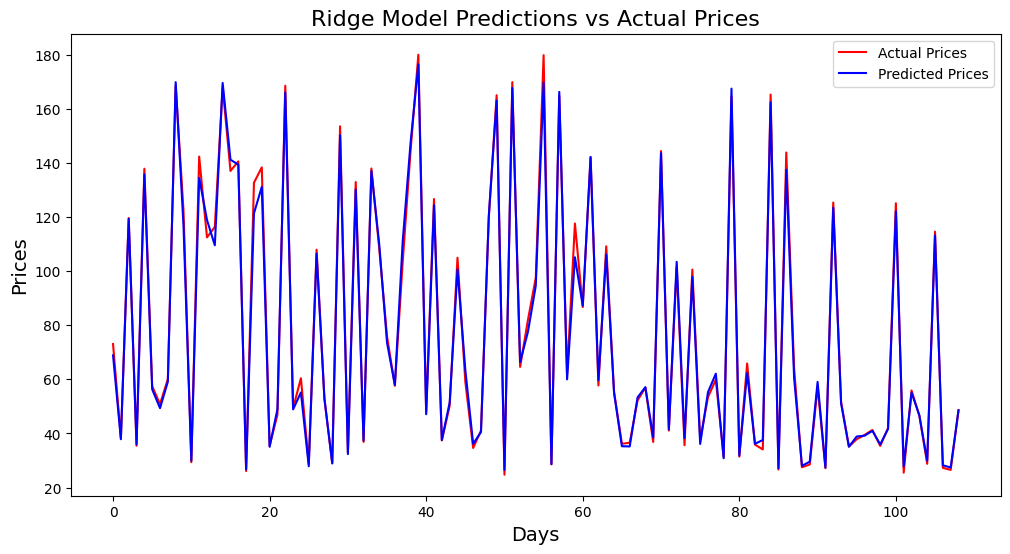

In [2]:
# Make predictions
predictions = ridge.predict(X_test)

# Inverse transform to get the original scale for predicted prices
predictions = scaler.inverse_transform(predictions.reshape(1,-1)).reshape(-1,1)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Ridge Model Predictions vs Actual Prices', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend()
plt.show()

####  Plotly interactive visualization
- Helps to zoom in and zoom out
- We can see the best prediction is biased towards the previous week price


In [4]:
import plotly.express as px
import plotly.graph_objects as go

trace1 = go.Scatter(x=dates[-len(y_test_scaled):], y=y_test_scaled.reshape(1,-1)[0], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=dates[-len(y_test_scaled):], y=predictions.reshape(1,-1)[0], mode='lines', name='predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and  Ridge Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()


#### LSTM 

#### 3.1 Build the model

In [22]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



#### 3.2 Change the shape for data set

In [21]:
X_train_in = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_in =X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

##### 3.3 Train and Test the model

In [ ]:
# Fit the model
model.fit(X_train_in, y_train, batch_size=32, epochs=100,verbose=False)

# Make predictions
predictions = model.predict(X_test_in)

# Inverse transform to get the original scale for predicted prices
predictions_scaled = scaler.inverse_transform(predictions)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


# Evaluate the model performance
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 0.0004847230928821605


#### Capture the predictions in data frame and combine with Ridge model

In [36]:
X_in= X.reshape(X.shape[0], X.shape[1], 1)
lstm_pred=model.predict(X_in)
lstm_pred_scaled=scaler.inverse_transform(lstm_pred)
result_df['lstm_predicted']=lstm_pred_scaled

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [37]:
result_df

,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,observed,ridge_predicted,lstm_predicted
0,27.0901,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,28.028206,28.940044
1,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,27.803593,28.866529
2,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,27.883090,28.917505
3,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,29.201765,29.482414
4,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,28.8876,29.361886,30.001873
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,165.1691,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,163.069013,160.963959
541,164.5200,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,165.992078,162.077759
542,167.2064,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,172.6500,167.187241,163.802292
543,164.8895,151.9268,158.3700,164.6400,165.2900,168.5600,164.5200,165.0500,166.9900,172.6500,179.8600,169.774999,169.279114


#### utility method to get metrics across multiple moodel

In [42]:

def accuracy(df_forecast, y_train_series, seasonallity):

    method = df_forecast.columns[1:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []
    dir_accuracy_results=[]
    
    def directional_accuracy(y_true, y_pred):
    # Compare directions of changes
        y_true_dir = np.sign(np.diff(y_true))
        y_pred_dir = np.sign(np.diff(y_pred))
        return np.mean(y_true_dir == y_pred_dir)

    y = df_forecast.observed.values
    scale = np.abs(y_train_series[:-seasonallity] - y_train_series[seasonallity:])
    scale = np.average(scale)

    for i in method:
        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs(d/y))*100
        mase = mae_f / scale
        dir_accuracy=directional_accuracy(y,y_hat)
        mae_results.append(np.round(mae_f,2))
        rmse_results.append(np.round(rmse_f,2))
        mape_results.append(np.round(mape,2))
        mase_results.append(np.round(mase,2))
        dir_accuracy_results.append(np.round(dir_accuracy,2))

    accuracy_df = pd.DataFrame({'Method':method,
                    'RMSE':rmse_results,
                    'MAE':mae_results,
                    'MAPE':mape_results,
                    'MASE':mase_results,
                   'DA':dir_accuracy_results })

    return accuracy_df

#### Compare the performance of the models

* DA - Directional Accuracy 
    * All the models have accuracy < 0.5
    * Not a great fit

In [45]:

accuracy(result_df[['observed','lag_1','ridge_predicted','lstm_predicted']], result_df['observed'].values, time_step)

,Method,RMSE,MAE,MAPE,MASE,DA
0,lag_1,3.49,2.31,2.80,0.33,0.48
1,ridge_predicted,3.42,2.28,2.81,0.33,0.49
2,lstm_predicted,3.75,2.59,3.30,0.37,0.49


#### Visualizing all the model predictions

In [48]:
import plotly.express as px
import plotly.graph_objects as go

trace1 = go.Scatter(x=df_stock.index[time_step:], y=result_df['observed'], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=df_stock.index[time_step:], y=result_df['lag_1'], mode='lines', name='lag 1')
trace3 = go.Scatter(x=df_stock.index[time_step:], y=result_df['ridge_predicted'], mode='lines', name='ridge predicted')
trace4 = go.Scatter(x=df_stock.index[time_step:], y=result_df['lstm_predicted'], mode='lines', name='lstm predicted')


# Create the layout
layout = go.Layout(
    title='Stock Price and Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2,trace3,trace4], layout=layout)

# Show the plot
fig.show()